In [1]:
# Ichiro Suzuki analytics(2015-2016)

# ライブラリのインポートと設定
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = 100
pd.options.display.max_rows = 300

In [2]:
# 変化球の正式名称(あとで使う)

PITCH_TYPE_NAME = {
    'CH': 'Change-up',
    'CU': 'Curveball',
    'EP': 'Ephuus',
    'FA': 'Fastball',
    'FC': 'Cut Fastball',
    'FF': 'four-seam Fastball',
    'FO': 'Forkball',
    'FS': 'Split-finger Fastball',
    'FT': 'two-seam Fastball',
    'KC': 'Knuckle Curve',
    'KN': 'Knuckleball',
    'SC': 'Screwball',
    'SI': 'Sinker',
    'SL': 'Slider',
    'UN': 'Unknown'
}

In [3]:
# 2015年の一年間および、2016年途中(開幕〜8/7まで)のデータセットを取る
ichiro_atbat_2015 = pd.read_csv('./output/datasets/ichiro_suzuki_2015_atbats.csv')
ichiro_pitchfx_2015 = pd.read_csv('./output/datasets/ichiro_suzuki_2015_pitchfx.csv')
ichiro_atbat_2016 = pd.read_csv('./output/datasets/ichiro_suzuki_2016_atbats.csv')
ichiro_pitchfx_2016 = pd.read_csv('./output/datasets/ichiro_suzuki_2016_pitchfx.csv')

In [4]:
# 時系列分析用に試合の日(game_day)および、変化球の正式名称を加える
for df in (ichiro_atbat_2015, ichiro_atbat_2016, ichiro_pitchfx_2015, ichiro_pitchfx_2016):
    df['game_day'] = pd.to_datetime(df[['year', 'month', 'day']])

In [5]:
# 試しに中を見てみる
ichiro_pitchfx_2015

,Unnamed: 0,Unnamed: 0.1,retro_game_id,year,month,day,st_fl,regseason_fl,playoff_fl,game_type,game_type_des,local_game_time,game_id,home_team_id,away_team_id,home_team_lg,away_team_lg,interleague_fl,park_id,park_name,park_location,inning_number,bat_home_id,outs_ct,pit_mlbid,pit_first_name,pit_last_name,pit_box_name,pit_hand_cd,bat_mlbid,bat_first_name,bat_last_name,bat_box_name,bat_hand_cd,ab_number,start_bases,end_bases,event_outs_ct,pa_ball_ct,pa_strike_ct,pitch_seq,pa_terminal_fl,pa_event_cd,pitch_res,pitch_des,pitch_id,x,y,start_speed,end_speed,sz_top,sz_bot,pfx_x,pfx_z,px,pz,x0,y0,z0,vx0,vy0,vz0,ax,ay,az,break_y,break_angle,break_length,pitch_type,pitch_type_seq,type_confidence,zone,spin_dir,spin_rate,sv_id,game_day
0,11977,452,MIA201504060,2015,4,6,F,T,F,R,Regular Season,16:10,413650,mia,atl,NL,NL,F,4169,Marlins Park,"Miami, FL",8,1,0,462382,Jim,Johnson,"Johnson, J",R,400085,Ichiro,Suzuki,"Suzuki, I",L,59,___,___,1,0,0,B,F,2,B,Ball,444,121.040000,144.580000,94.1,86.2,3.39,1.50,-8.46,3.02,-0.106,3.489,-1.623,50.0,6.531,7.092,-137.858,-3.393,-16.149,33.038,-26.342,23.8,28.1,6.6,FT,FT,0.905,11.0,250.143,1806.907,150406_185231,2015-04-06
1,11978,453,MIA201504060,2015,4,6,F,T,F,R,Regular Season,16:10,413650,mia,atl,NL,NL,F,4169,Marlins Park,"Miami, FL",8,1,0,462382,Jim,Johnson,"Johnson, J",R,400085,Ichiro,Suzuki,"Suzuki, I",L,59,___,___,1,1,0,BB,F,2,B,Ball,445,80.640000,210.300000,95.0,87.1,3.31,1.50,-11.24,3.58,0.954,1.055,-1.579,50.0,6.312,10.881,-138.581,-9.713,-21.675,33.359,-25.200,23.8,35.0,7.1,FT,FT|FT,0.906,14.0,252.164,2383.684,150406_185244,2015-04-06
2,11979,454,MIA201504060,2015,4,6,F,T,F,R,Regular Season,16:10,413650,mia,atl,NL,NL,F,4169,Marlins Park,"Miami, FL",8,1,0,462382,Jim,Johnson,"Johnson, J",R,400085,Ichiro,Suzuki,"Suzuki, I",L,59,___,___,1,2,0,BBX,T,2,X,"In play, out(s)",446,97.600000,193.390000,94.2,86.6,3.58,1.50,-2.67,9.90,0.509,1.681,-1.409,50.0,6.527,6.149,-137.669,-10.728,-5.115,31.553,-13.158,23.8,13.6,3.4,FF,FT|FT|FF,0.893,9.0,195.054,2075.172,150406_185306,2015-04-06
3,15735,483,MIA201504070,2015,4,7,F,T,F,R,Regular Season,19:10,413665,mia,atl,NL,NL,F,4169,Marlins Park,"Miami, FL",7,1,2,592533,Cody,Martin,"Martin, Co",R,400085,Ichiro,Suzuki,"Suzuki, I",L,61,___,___,3,0,0,S,F,2,S,Called Strike,518,120.470000,194.180000,88.3,81.3,3.48,1.50,-3.12,8.73,-0.091,1.652,-2.389,50.0,5.550,6.889,-129.152,-6.521,-5.265,27.319,-17.386,23.8,11.7,4.6,FF,FF,2.000,8.0,199.596,1763.299,150407_213639,2015-04-07
4,15736,484,MIA201504070,2015,4,7,F,T,F,R,Regular Season,19:10,413665,mia,atl,NL,NL,F,4169,Marlins Park,"Miami, FL",7,1,2,592533,Cody,Martin,"Martin, Co",R,400085,Ichiro,Suzuki,"Suzuki, I",L,61,___,___,3,0,1,SX,T,2,X,"In play, out(s)",519,135.870000,183.050000,87.7,80.8,3.43,1.50,-8.13,4.58,-0.495,2.064,-2.553,50.0,5.256,7.889,-128.321,-3.257,-13.564,26.537,-24.470,23.8,25.5,6.8,FT,FF|FT,2.000,7.0,240.404,1763.622,150407_213653,2015-04-07
5,17762,486,MIA201504080,2015,4,8,F,T,F,R,Regular Season,19:10,413672,mia,atl,NL,NL,F,4169,Marlins Park,"Miami, FL",7,1,2,501593,Luis,Avilan,Avilan,L,400085,Ichiro,Suzuki,"Suzuki, I",L,53,___,1__,2,0,0,B,F,20,B,Ball,429,72.670000,173.360000,93.4,85.5,3.43,1.50,12.49,6.13,1.160,2.420,1.400,50.0,5.620,-5.000,-136.800,-4.780,23.470,32.580,-20.580,23.8,-45.8,6.7,FT,FT,2.000,14.0,116.290,2776.159,150408_211809,2015-04-08
6,17763,487,MIA201504080,2015,4,8,F,T,F,R,Regular Season,19:10,413672,mia,atl,NL,NL,F,4169,Marlins Park,"Miami, FL",7,1,2,501593,Luis,Avilan,Avilan,L,400085,Ichiro,Suzuki,"Suzuki, I",L,53,___,1__,2,1,0,BX,T,20,X,"In play, no out",430,79.610000,160.780000,92.9,85.1,3.43,1.50,13.20,4.64,0.980,2.890,1.390,50.0,5.590,-5.670,-136.050,-2.840,24.570,31.690,-23.460,23.8,-44.0,7.3,FT,FT|FT,2.000,12.0,109.528,2779.946,150408_211824,2015-04-08
7,28217,4098,MIA201504100,2015,4,10,F,T,F,R,Regular Season,19:10,413708,mia,tba,NL,AL,T,4169,Marlins Park,"Miami, FL",8,1,2,457117,Ernesto,Frieri,Frieri,R,400085,Ichiro,Suzuki,"Suzuki, I",L,76,12_,___,3,0,0,S,F,2,S,Foul,678,126.7200

In [6]:
# pitchfxデータから、ヒットとなった投球を抽出

# 条件式(共通)
QUERY_TEMPLATE = "pitch_res == 'X' and pa_event_cd in [{}]"

# ヒットの条件(コード値はRETROSHEETの仕様に従う)
query_hits = QUERY_TEMPLATE.format(','.join(['20', '21', '22', '23']))
ichiro_pitchfx_2015_hits = ichiro_pitchfx_2015.query(query_hits)
ichiro_pitchfx_2016_hits = ichiro_pitchfx_2016.query(query_hits)

In [7]:
# まずは軽くDataframeを眺める

# 初速・終速・回転数の統計を見てみる(2015)
ichiro_pitchfx_2015_hits[['start_speed', 'end_speed', 'spin_rate']].describe()

,start_speed,end_speed,spin_rate
count,91.000000,91.000000,91.000000
mean,88.816484,81.559341,1813.112868
std,5.604844,5.017303,606.246627
min,75.500000,69.200000,174.172000
25%,85.600000,78.450000,1573.624000
50%,90.900000,83.200000,1977.150000
75%,92.900000,85.300000,2224.841000
max,97.000000,89.500000,2779.946000


In [8]:
# 初速・終速・回転数の統計を見てみる(2016)
ichiro_pitchfx_2016_hits[['start_speed', 'end_speed', 'spin_rate']].describe()

,start_speed,end_speed,spin_rate
count,65.000000,65.000000,65.000000
mean,88.406154,81.506154,1826.277600
std,6.021988,5.385132,693.978934
min,74.500000,68.400000,170.475000
25%,83.500000,77.600000,1389.529000
50%,91.200000,83.600000,1974.543000
75%,92.900000,85.500000,2234.932000
max,96.600000,89.500000,3062.737000


In [9]:
# ちょっとイマイチわかりにくいので軽く可視化してみる

In [10]:
# まずはヒットの傾向を探ってみる. ヒットに仕留めた変化球ごとに集計してみる
pitch_types_2015 = ichiro_pitchfx_2015_hits.pitch_type.groupby(ichiro_pitchfx_2015_hits.pitch_type).count()
pitch_types_2016 = ichiro_pitchfx_2016_hits.pitch_type.groupby(ichiro_pitchfx_2016_hits.pitch_type).count()

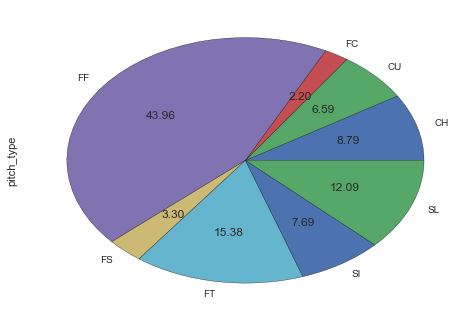

In [11]:
# ヒットにした変化球の割合(2015)
pitch_types_2015.plot.pie(autopct='%.2f')


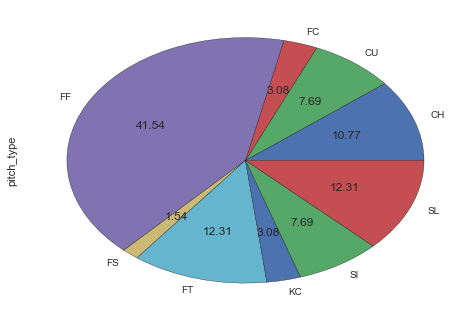

In [12]:
# 速球系を中心に打ち込んでいる、2016年は?
pitch_types_2016.plot.pie(autopct='%.2f')


In [13]:
# 多少変化球を打ってる以外変わらないかも...次はアウトになった時の変化球をみる
query_outs = QUERY_TEMPLATE.format(','.join(['2']))
ichiro_pitchfx_2015_outs = ichiro_pitchfx_2015.query(query_outs)
ichiro_pitchfx_2016_outs = ichiro_pitchfx_2016.query(query_outs)

In [14]:
# アウトの傾向を探ってみる. ヒットに仕留めた変化球ごとに集計してみる
pitch_types_2015_outs = ichiro_pitchfx_2015_outs.pitch_type.groupby(ichiro_pitchfx_2015_outs.pitch_type).count()
pitch_types_2016_outs = ichiro_pitchfx_2016_outs.pitch_type.groupby(ichiro_pitchfx_2016_outs.pitch_type).count()

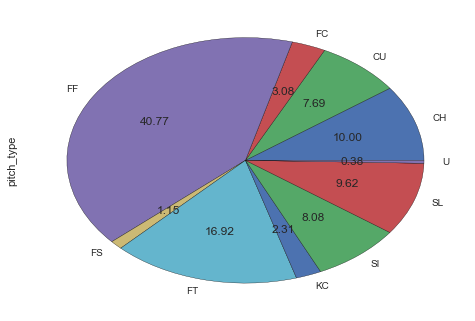

In [15]:
# アウトになった変化球の割合(2015)、速球系に苦戦してる
pitch_types_2015_outs.plot.pie(autopct='%.2f')

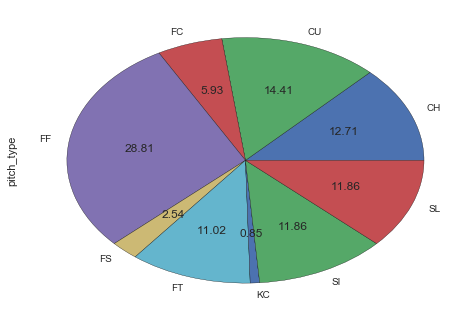

In [16]:
# アウトになった変化球の割合(2016)、変化球系にやられてる(ちょっと違いが出てきた！)
pitch_types_2016_outs.plot.pie(autopct='%.2f')

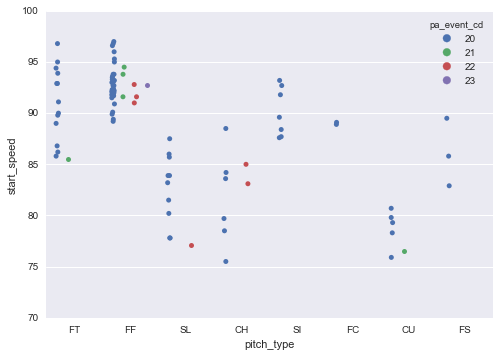

In [17]:
# さらに詳しく、ヒットの傾向をみてみる.

# X軸:球種 Y軸: 球速(初速)でヒット/アウトのゾーンを把握してみる

# pa_event_cd(打席でのイベントID):は、 20:単打, 21:二塁打, 22:三塁打, 23:本塁打

sns.stripplot(x='pitch_type', y='start_speed', data=ichiro_pitchfx_2015_hits,  hue='pa_event_cd', split=True, jitter=True)

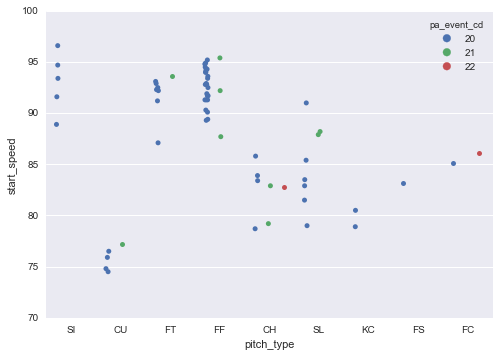

In [18]:
# 同じ条件で2016年も見る
sns.stripplot(x='pitch_type', y='start_speed', data=ichiro_pitchfx_2016_hits,  hue='pa_event_cd', split=True, jitter=True)

In [19]:
# 2016年の三塁打はCH(チェンジアップ)とFC(Cut Fastball)を打ち込んでるっぽい、興味深いので見てみる
ichiro_pitchfx_2016_hits.query('pa_event_cd == 22')

,Unnamed: 0,Unnamed: 0.1,retro_game_id,year,month,day,st_fl,regseason_fl,playoff_fl,game_type,game_type_des,local_game_time,game_id,home_team_id,away_team_id,home_team_lg,away_team_lg,interleague_fl,park_id,park_name,park_location,inning_number,bat_home_id,outs_ct,pit_mlbid,pit_first_name,pit_last_name,pit_box_name,pit_hand_cd,bat_mlbid,bat_first_name,bat_last_name,bat_box_name,bat_hand_cd,ab_number,start_bases,end_bases,event_outs_ct,pa_ball_ct,pa_strike_ct,pitch_seq,pa_terminal_fl,pa_event_cd,pitch_res,pitch_des,pitch_id,x,y,start_speed,end_speed,sz_top,sz_bot,pfx_x,pfx_z,px,pz,x0,y0,z0,vx0,vy0,vz0,ax,ay,az,break_y,break_angle,break_length,pitch_type,pitch_type_seq,type_confidence,zone,spin_dir,spin_rate,sv_id,game_day
723,362869,2904,ATL201607020,2016,7,2,F,T,F,R,Regular Season,16:10,448081,atl,mia,NL,NL,F,16,Turner Field,"Atlanta, GA",3,0,2,449173,Lucas,Harrell,"Harrell, L",R,400085,Ichiro,Suzuki,"Suzuki, I",L,19,_2_,__3,2,2,2,SSBBX,T,22,X,"In play, run(s)",144,140.98,179.89,82.8,77.4,3.39,1.46,-8.00,6.65,-0.629,2.181,-2.433,50.0,6.030,6.846,-121.087,-4.670,-12.064,20.291,-22.077,23.9,25.7,6.8,CH,FT|SL|CU|FT|CH,0.905,4.0,230.071,1884.877,160702_164701,2016-07-02
946,493517,2256,COL201608070,2016,8,7,F,T,F,R,Regular Season,14:10,448525,col,mia,NL,NL,F,19,Coors Field,"Denver, CO",7,0,1,543734,Chris,Rusin,Rusin,L,400085,Ichiro,Suzuki,"Suzuki, I",L,60,___,__3,1,2,0,BBX,T,22,X,"In play, no out",499,116.73,175.49,86.1,80.8,3.39,1.46,2.86,2.38,0.007,2.344,2.015,50.0,5.919,-5.971,-126.155,-3.343,4.691,21.671,-28.199,23.9,-7.4,7.1,FC,FC|SI|FC,0.894,5.0,130.278,707.097,160807_163801,2016-08-07
